# Milestone Project 2: SkimLit📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that will be using) is avalaible here: https://arxiv.org/pdf/1710.06071.pdf

And reading through the paper above, we see that the model architecture that they use to achieve their best results is avalaible here:https://arxiv.org/pdf/1612.05251.pdf

📖 **Resources:** If you want to find the ground thruth for this notebook (with lots of diagrams and text annotations), see the GitHub:
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they use.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [5]:
import os
os.listdir("pubmed-rct") 

['.git',
 'PubMed_200k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign',
 'README.md']

In [6]:
# Check what files are in the PubMed_20K dataset
os.listdir("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign")

['dev.txt', 'test.txt', 'train.txt']

In [7]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [8]:
# Check all of the filenames in the target directory
filenames = [data_dir + "/" + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best way to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [9]:
# Create function to read the lines of a document 
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.
    
    Args: 
        filename: a string containing the target filepath.
    
    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [10]:
# Let's read in the training lines
train_lines = get_lines(data_dir+ "/"+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How I think our data will be best represented...

```
[{'line_number: 0, 
    'target':'BACKGROUND',
    'text':"Emotional eating is associated with overeating and the development of obesity .\n",
    'total_lines':11}, 
    ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [11]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionnaries of abstract line data.
    
    Takes in filename, reads it contents and sorts through each line,
    extrating things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number the
    target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts
    
    # Loop through each line in the target line
    for line in input_lines:
        if line.startswith("###"): # Check if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is ID line
        elif line.isspace(): # check to see if line is a newline    
            abstract_line_split = abstract_lines.splitlines() # Split abstract into seperate lines
            
            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data ["line_number"] = abstract_line_number # what number line does the line appear in the abstract ?
                line_data["total_lines"] = len(abstract_line_split) # how many total lines are there in the target abstract ? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract sample list
        
        else: # if the above conditions aren't fullfilled, the line contains a labelled sentence
            abstract_lines += line
        
    return abstract_samples

In [12]:
# Get data from file and preprocess it
import timeit

start_time = timeit.default_timer()

train_samples = preprocess_text_with_line_numbers(data_dir+ "/"+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+ "/"+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+ "/"+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

end_time = timeit.default_timer()
execution_time = end_time - start_time

print("Temps d'exécution:", execution_time)

180040 30212 30135
Temps d'exécution: 0.3986399997957051


In [13]:
# Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it ?

In [14]:
import pandas as pd

In [15]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [16]:
# Distribution of labels in training data
train_df_num = train_df.target.value_counts().sort_values(ascending=True)
train_df_num = pd.DataFrame({"id":train_df_num.index,
                            "target":train_df_num.values})
train_df_num

,id,target
0,OBJECTIVE,13839
1,BACKGROUND,21727
2,CONCLUSIONS,27168
3,RESULTS,57953
4,METHODS,59353


In [17]:
import matplotlib.pyplot as plt

(0.0, 62320.65)

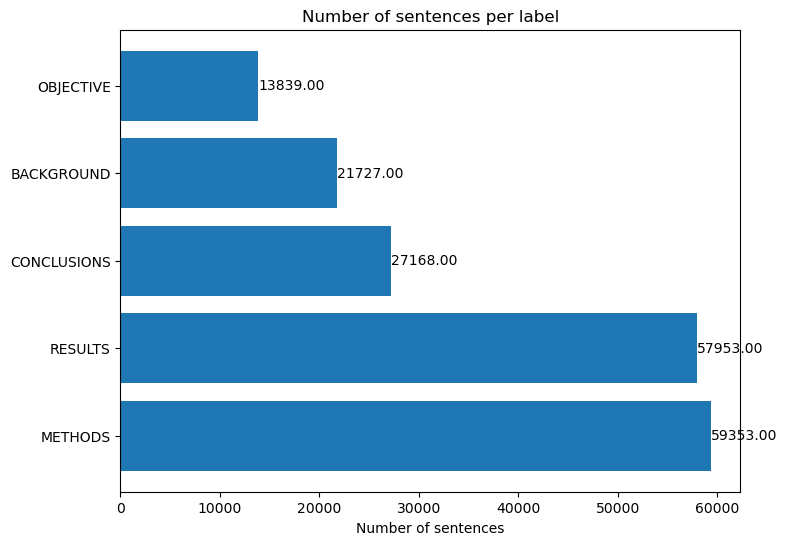

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
scores = ax.barh(range(len(train_df_num.target)), train_df_num.target.values) # get f1-score values
ax.set_yticks(range(len(train_df_num.target)))
ax.set_yticklabels(train_df_num.id)
ax.set_xlabel("Number of sentences")
ax.set_title("Number of sentences per label")
ax.invert_yaxis(); # Reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html)

ax.bar_label(scores, fmt='%.2f')
ax.set_xlim() 

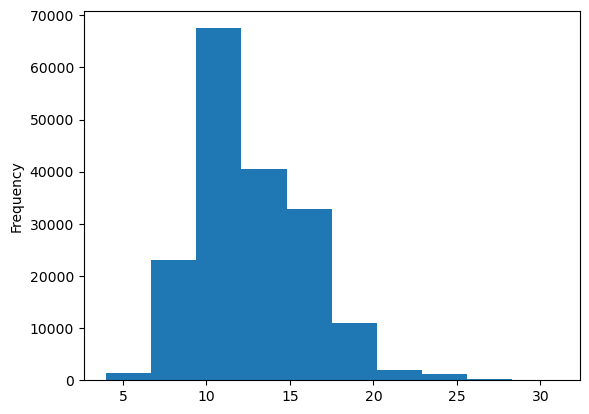

In [19]:
# Let's check the lenght of different abstract
train_df.total_lines.plot.hist();

### Get lists of sentences

In [20]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)


In [22]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

In [23]:
one_hot_encoder = OneHotEncoder(sparse_output=False) # We want a non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1)) # already fit
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [24]:
!pip install tensorflow

In [25]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [26]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [27]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes Classifier).

## Model 0: Getting a baseline

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # Model
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

### Download helper function script
In the previous function, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script.

In [29]:
# Get our helper functions
with open("helper_functions.py", "r") as fichier:
    contenu = fichier.read()

In [30]:
# Import series of helper functions for our notebook
from helper_functions import calculate_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [31]:
import numpy as np

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [32]:
# How long is each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

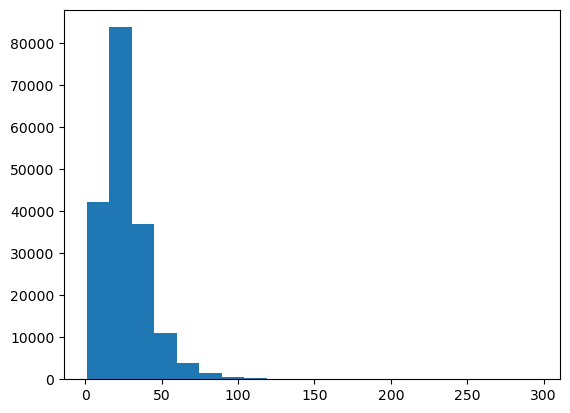

In [33]:
# What's the distribution look like ?
plt.hist(sent_lens, bins=20);

In [34]:
# How long of a sentence lenght covers 95% of examples ?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
# Maximum sequence lenght in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [36]:
# How many words are in our vacabulary ? (Taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [37]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [38]:
# Create a text vectorizer 
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode="int",
                                    output_sequence_length=output_seq_len)

In [39]:
# Fit the text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [40]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
in art-naive hiv-infected adults , @-month supplementation with a single supplement containing multivitamins and selenium was safe and significantly reduced the risk of immune decline and morbidity .

Length of text: 199

Vectorized text: [[    5 10075  1861   266   178   464     7     8   312  1707   866  8225
      3  4745    10   514     3    39   191     2    73     4   988  1078
      3   807     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [41]:
# How many words in our training vocabulary ?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in a vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in a vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding


In [43]:
# Create token embedding layer
from tensorflow.keras import layers 

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # set input shape
                               output_dim=128, # neural networks work very well with numbers that are divisible by 8.
                               mask_zero=True, # use masking to handle variable sequence lenghts (save space)
                               name="token_embedding")

In [44]:
# Show example embedding 
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 in art-naive hiv-infected adults , @-month supplementation with a single supplement containing multivitamins and selenium was safe and significantly reduced the risk of immune decline and morbidity .

Sentence after vectorization (before embedding):
 [[    5 10075  1861   266   178   464     7     8   312  1707   866  8225
      3  4745    10   514     3    39   191     2    73     4   988  1078
      3   807     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[-0.02165369  0.04060334  0.01160408 ... -0.03182483 -0.0055906
    0.033075  ]
  [ 0.04252739 -0.04118509  0.03585687 ...  0.02866558  0.04758051
   -0.03895529]
  [ 0.03530485 -0.03692796  0.04003752 ... -0.02505503  0.04137019
    0.03338965]
  ...
  [-0.02836253 -0.00815744  0.04806056 ...  0.00479417  0.04418567
   -0.02605763]
  [-0.02836

## Creating datasets (making sure our data loads as faster as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance?hl=fr
* https://www.tensorflow.org/guide/data?hl=fr

In [45]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # how many samples should we prefecth at a time (buffer_size)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [47]:
# Create 1D Conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
print(x.shape)
x = layers.Conv1D(64,
                  5,
                  activation="relu",
                  padding="same")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs, name="model_1_Convolutional")

(None, 55, 128)
(None, 55, 64)
(None, 64)


In [48]:
# Get a summary()
model_1.summary()

Model: "model_1_Convolutional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)       

In [49]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 38s 66ms/step - loss: 0.8270 - accuracy: 0.6874 - val_loss: 0.5814 - val_accuracy: 0.7862
Epoch 2/3
562/562 [==============================] - 39s 70ms/step - loss: 0.5742 - accuracy: 0.7890 - val_loss: 0.5394 - val_accuracy: 0.7989
Epoch 3/3
562/562 [==============================] - 40s 70ms/step - loss: 0.5442 - accuracy: 0.8005 - val_loss: 0.5218 - val_accuracy: 0.8068


In [51]:
# Evaluate on all validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5215 - accuracy: 0.8064


[0.5214830636978149, 0.8064345121383667]

In [52]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[6.4729875e-01, 9.0039372e-02, 2.7937660e-04, 2.6082331e-01,
         1.5591317e-03],
        [3.1088763e-01, 5.6969202e-01, 1.3202723e-03, 1.1579398e-01,
         2.3060879e-03],
        [1.7588720e-01, 4.5041740e-03, 2.1660703e-03, 8.1730503e-01,
         1.3750081e-04],
        ...,
        [3.2729784e-04, 1.6007768e-03, 1.6151700e-02, 2.1118841e-04,
         9.8170912e-01],
        [1.1767411e-02, 6.4585799e-01, 3.3754867e-02, 1.7047049e-02,
         2.9157275e-01],
        [1.0851649e-02, 9.8077112e-01, 1.4127858e-03, 2.2917686e-03,
         4.6726470e-03]], dtype=float32),
 (30212, 5))

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(tf.squeeze(model_1_pred_probs), axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 4, 4, 2, 4, 1], dtype=int64)>

In [54]:
# Calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 80.64345293260956,
 'precision': 0.8042033666386992,
 'recall': 0.8064345293260956,
 'f1': 0.8045966104286676}

In [55]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [56]:
!pip install tensorflow_hub

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE):
https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layers = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         trainable=False,
                                         name="USE")

In [53]:
# Test out the pretrained model embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layers([random_train_sentence])
print(f"This is an embedded sentence:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of embedded sentence:\n {len(use_embedded_sentence[0])}")

Random sentence:
 patient data were assessed to determine when and how often changes in insulin parameter settings occurred during the study .
This is an embedded sentence:
 [ 0.06702601  0.00730249 -0.06325617  0.0055012  -0.01815716 -0.04484035
  0.04575548  0.00952326 -0.00408253  0.06077483  0.08624963  0.0304551
  0.07726696 -0.05262163 -0.05479982 -0.02028712 -0.08612359  0.05216523
 -0.03596515 -0.03921834  0.03273502  0.06328288 -0.01558539 -0.00119685
  0.00134219 -0.0023265   0.04449325  0.04821396 -0.06635138 -0.05789204]

Length of embedded sentence:
 512


### Building and fitting an NLP sequential model using pretrained embeddings from TensorFlow Hub

In [59]:
# Create model using the Sequential API
model_2 = tf.keras.Sequential([
  tf_hub_embedding_layers,
  layers.Dense(128, activation="relu"),
# Note: you can add layers here if you want to.
  layers.Dense(num_classes, activation="softmax")
],name="model_2_USE")

In [60]:
# Compile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# train a classifier on top of USE pretrained embeddings
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                           )

Epoch 1/3
562/562 [==============================] - 7s 7ms/step - loss: 0.9194 - accuracy: 0.6485 - val_loss: 0.7950 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7665 - accuracy: 0.7013 - val_loss: 0.7525 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7495 - accuracy: 0.7127 - val_loss: 0.7356 - val_accuracy: 0.7124


In [62]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7386 - accuracy: 0.7150


[0.7386333346366882, 0.7150139212608337]

### Build in  NLP feature extraction


In [54]:
inputs = layers.Input(shape=[], dtype="string") # inputs are 1-dimensional strings
x = tf_hub_embedding_layers(inputs) # turn the input text into numbers
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer, want binary outputs so use sigmoïd activation function.
model_2_fe = tf.keras.Model(inputs, outputs, name="model_2_seq")

In [65]:
# Compile 
model_2_fe.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
model_2_fe.summary()

Model: "model_2_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [67]:
# train a classifier on top of USE pretrained embeddings
model_2_fe_history = model_2_fe.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))
                           )

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9127 - accuracy: 0.6523 - val_loss: 0.7959 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7693 - accuracy: 0.7016 - val_loss: 0.7556 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7525 - accuracy: 0.7121 - val_loss: 0.7403 - val_accuracy: 0.7101


In [68]:
model_2_fe.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.7416 - accuracy: 0.7134


[0.7416486144065857, 0.7134250998497009]

In [69]:
# Make predictions with feature extraction model
model_2_fe_pred_prob = model_2_fe.predict(valid_dataset)
model_2_fe_pred_prob

945/945 [==============================] - 5s 5ms/step


array([[4.2688778e-01, 3.7092203e-01, 2.3531527e-03, 1.9161555e-01,
        8.2213981e-03],
       [2.9698300e-01, 5.4275084e-01, 3.4891330e-03, 1.5404488e-01,
        2.7321121e-03],
       [2.3571220e-01, 1.3753790e-01, 1.5132895e-02, 5.7824975e-01,
        3.3367224e-02],
       ...,
       [1.6679561e-03, 6.2918267e-03, 5.6617115e-02, 8.6841779e-04,
        9.3455470e-01],
       [4.4682412e-03, 4.9858164e-02, 1.8528809e-01, 1.6718043e-03,
        7.5871378e-01],
       [1.7806987e-01, 2.7147040e-01, 4.7547913e-01, 6.6123875e-03,
        6.8368249e-02]], dtype=float32)

In [70]:
# Convert the predictions probabilities
model_2_fe_preds = tf.argmax(model_2_fe_pred_prob, axis=1)
model_2_fe_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [71]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_fe_results = calculate_results(y_true=val_labels_encoded,
                                       y_pred=model_2_fe_preds)
model_2_fe_results

{'accuracy': 71.34251290877796,
 'precision': 0.7136911857126285,
 'recall': 0.7134251290877797,
 'f1': 0.710515950344476}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've made token level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [55]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [56]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character sequence into characters
split_chars(random_train_sentence)

'p a t i e n t   d a t a   w e r e   a s s e s s e d   t o   d e t e r m i n e   w h e n   a n d   h o w   o f t e n   c h a n g e s   i n   i n s u l i n   p a r a m e t e r   s e t t i n g s   o c c u r r e d   d u r i n g   t h e   s t u d y   .'

In [57]:
# Split sequence-level data splits into character-level data splits.
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
# What's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

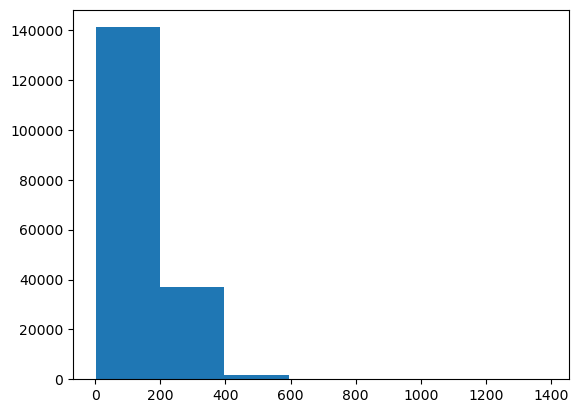

In [59]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [60]:
# How long of a character lenght covers 95% of examples ?
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
# Maximum character lenght in the training set
max(char_lens)

1386

In [62]:
# get all keyboards characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation + " " + "[UNK]" #Out Of Vocab
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ [UNK]'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) 
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                   # standardize=None, if you want to leave punctuation in
                                    name="char_vectorizer")

In [64]:
# Adapt to our training characters
char_vectorizer.adapt(train_chars)

In [65]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [66]:
# Test our character vectorization
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random train:\n {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")      
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 i n t e r l e u k i n   @   l e v e l s   w e r e   s i g n i f i c a n t l y   h i g h e r   i n   p r o p o f o l   t h a n   i n   s e v o f l u r a n e   g r o u p   (   p   =   @   )   .
Length of random train:
 79

Vectorized chars:
 [[ 4  6  3  2  8 12  2 16 23  4  6 12  2 21  2 12  9 20  2  8  2  9  4 18
   6  4 17  4 11  5  6  3 12 19 13  4 18 13  2  8  4  6 14  8  7 14  7 17
   7 12  3 13  5  6  4  6  9  2 21  7 17 12 16  8  5  6  2 18  8  7 16 14
  14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   

### Creating a character-level embedding


In [67]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # This is the length of the char embedding in the paper (fig 1)
                              mask_zero=True,
                              name="char_embed")

In [68]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded char after vectorization:\n {char_embed_example}")
print(f"Char embedding shape:\n {char_embed_example.shape}")

Charified text:
 i n t e r l e u k i n   @   l e v e l s   w e r e   s i g n i f i c a n t l y   h i g h e r   i n   p r o p o f o l   t h a n   i n   s e v o f l u r a n e   g r o u p   (   p   =   @   )   .

Embeded char after vectorization:
 [[[-0.0332762   0.01118414  0.02924243 ... -0.01994907 -0.00732509
   -0.04062444]
  [-0.04865948  0.01429548 -0.04338644 ...  0.03301201  0.04092589
    0.00338731]
  [-0.03446671  0.01385541  0.04853754 ... -0.02636047 -0.01788748
    0.04018914]
  ...
  [ 0.02266666 -0.01295284  0.04124622 ... -0.00924204  0.03511531
   -0.00117397]
  [ 0.02266666 -0.01295284  0.04124622 ... -0.00924204  0.03511531
   -0.00117397]
  [ 0.02266666 -0.01295284  0.04124622 ... -0.00924204  0.03511531
   -0.00117397]]]
Char embedding shape:
 (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [69]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
print(x.shape)
x = layers.Conv1D(64,
                  5,
                  activation="relu",
                  padding="same")(char_embeddings)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs, name="model_3_Convolutional_char_embeddings")

(None, 128)
(None, 290, 64)
(None, 64)


In [87]:
# Get a summary()
model_3.summary()

Model: "model_3_Convolutional_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             

In [88]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # how many samples should we prefecth at a time (buffer_size)
valid_char_dataset = valid_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [91]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1*len(valid_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2526 - accuracy: 0.4925 - val_loss: 1.0380 - val_accuracy: 0.5974
Epoch 2/3
562/562 [==============================] - 6s 12ms/step - loss: 1.0034 - accuracy: 0.6027 - val_loss: 0.9390 - val_accuracy: 0.6283
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.9297 - accuracy: 0.6343 - val_loss: 0.8746 - val_accuracy: 0.6609


In [92]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.15687197, 0.32212105, 0.27714697, 0.20577289, 0.03808706],
       [0.13096203, 0.6516997 , 0.01696106, 0.11655581, 0.0838213 ],
       [0.09702574, 0.08994402, 0.42266196, 0.26143774, 0.12893057],
       ...,
       [0.02335813, 0.02580078, 0.21531545, 0.03824497, 0.6972807 ],
       [0.06732275, 0.06970783, 0.34579885, 0.05496976, 0.4622008 ],
       [0.3637101 , 0.39187306, 0.14890906, 0.05947156, 0.03603628]],
      dtype=float32)

In [93]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1], dtype=int64)>

In [94]:
# Calculate the results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 65.06686084999338,
 'precision': 0.6414781422067051,
 'recall': 0.6506686084999338,
 'f1': 0.6396639910344504}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_2`)
2. Create a character-level embedding model (similar `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [95]:
# Model 2
# inputs = layers.Input(shape=[], dtype="string") # inputs are 1-dimensional strings
# x = tf_hub_embedding_layers(inputs) # turn the input text into numbers
# x = layers.Dense(128, activation="relu")(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x) # Create the output layer, want binary outputs so use sigmoïd activation function.
# model_2_fe = tf.keras.Model(inputs, outputs, name="model_2_seq")

In [96]:
# Model 3
# inputs = layers.Input(shape=(1,), dtype=tf.string)
# char_vectors = char_vectorizer(inputs)
# char_embeddings = char_embed(char_vectors)
# x = layers.Conv1D(64,
#                   5,
#                   activation="relu",
#                   padding="same")(char_embeddings)
# x = layers.GlobalMaxPool1D()(x)
# outputs = layers.Dense(num_classes, activation="softmax")(x)
# model_3 = tf.keras.Model(inputs,outputs, name="model_3_Convolutional_char_embeddings")

In [72]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = tf_hub_embedding_layers(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="dense_token")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

In [73]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm =  layers.Bidirectional(layers.LSTM(25))(char_embeddings) # Fig 1 of the paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [74]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

In [75]:
# 4. Create output layers - adding in Dropout, discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat) # drop 50% of the weight at each step
combined_dense = layers.Dense(128, activation="relu", name="dense_combined")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax", name="dense_final")(final_dropout)

In [77]:
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [102]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

In [103]:
!pip install pydot

In [104]:
!pip install graphviz 

In [68]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/bin/graphviz'  # Replace with the actual path to the Graphviz executable

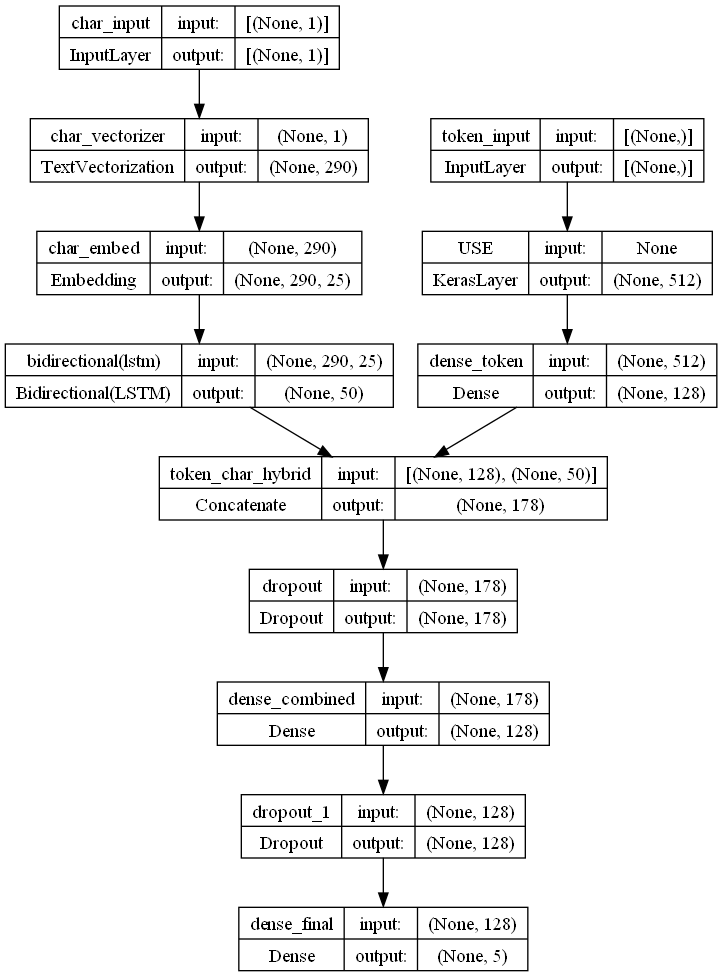

In [78]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [107]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [79]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Create in the same order than the input of the models
train_token_char_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_label)) # Combine data and label

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [80]:
# Repeat the above steps for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_label)) # Combine data and label

# Prefetch and batch train data
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Checkout our training char and token embedding dataset
train_token_char_dataset, val_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences


In [111]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 76s 123ms/step - loss: 0.9865 - accuracy: 0.6047 - val_loss: 0.7823 - val_accuracy: 0.7061
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.8039 - accuracy: 0.6875 - val_loss: 0.7181 - val_accuracy: 0.7284
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.7796 - accuracy: 0.6988 - val_loss: 0.6909 - val_accuracy: 0.7473


In [112]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.6948 - accuracy: 0.7358


[0.6947858929634094, 0.735833466053009]

In [113]:
# Make prediction using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 26s 25ms/step


array([[4.2583069e-01, 3.9973941e-01, 5.4714177e-03, 1.6015074e-01,
        8.8078277e-03],
       [3.8878098e-01, 4.2713249e-01, 3.9166561e-03, 1.7800246e-01,
        2.1674174e-03],
       [2.8906938e-01, 1.2521283e-01, 4.4097401e-02, 5.0840575e-01,
        3.3214718e-02],
       ...,
       [6.1310577e-04, 1.1861637e-02, 5.9109066e-02, 2.8361147e-04,
        9.2813259e-01],
       [6.9891927e-03, 5.9325140e-02, 2.3100595e-01, 3.4864289e-03,
        6.9919330e-01],
       [1.9275129e-01, 4.4555062e-01, 2.7020174e-01, 1.7580541e-02,
        7.3915742e-02]], dtype=float32)

In [114]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [115]:
# Gets results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.5833443664769,
 'precision': 0.7365121618113692,
 'recall': 0.735833443664769,
 'f1': 0.7327058798769077}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [116]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings


In [117]:
# How many different line numbers are there ?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

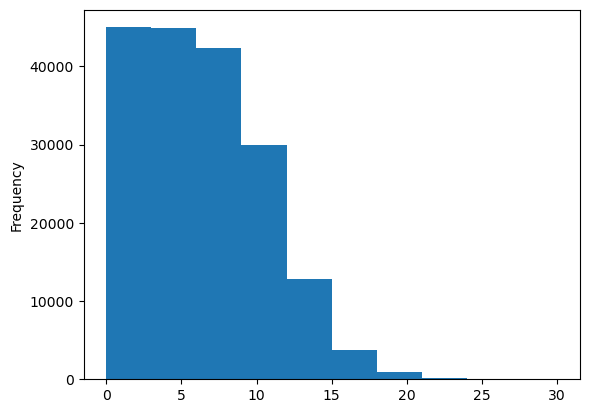

In [118]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [82]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [120]:
# How many number of lines are there ?
train_df["total_lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

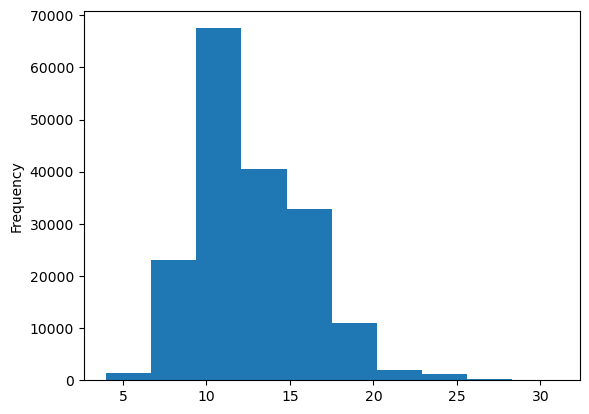

In [121]:
# Check the distribution of total lines
train_df.total_lines.plot.hist()

In [122]:
# Check the coverage of a "total_lines" value of 20 
np.percentile(train_df.total_lines, 98)

21.0

In [83]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=21)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=21)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=21)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 21]),
 <tf.Tensor: shape=(10, 21), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.,

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total lines" feature
5. Combine the ouputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the output of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the outputs of 1, 2, 3 & 4 and outputs of 7 into a tf.keras.Model 

In [84]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = tf_hub_embedding_layers(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="dense_token")(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm =  layers.Bidirectional(layers.LSTM(25))(char_embeddings) # Fig 1 of the paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Positional or feature embeddings

# 3. Line numbers model
# inputs, shape=?
# dense layer with 32 units & relu activation
# combine inputs & dense layer into model
line_number_input = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_output = layers.Dense(32, "relu")(line_number_input)
line_number_model = tf.keras.Model(inputs=line_number_input,
                                   outputs=line_number_output)

# 4. Total lines
total_lines_input = layers.Input(shape=(21,), dtype=tf.float32, name="total_lines_input")
total_lines_output = layers.Dense(32, "relu")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output)

# 5. Combine the ouputs of token & char
combine_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,                                                                            char_model.output])
x = layers.Dense(256, activation="relu")(combine_embeddings)
x = layers.Dropout(0.5)(x)

# 6. Combine positional embedding with combined token and char embeddings 
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 x])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [129]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['t

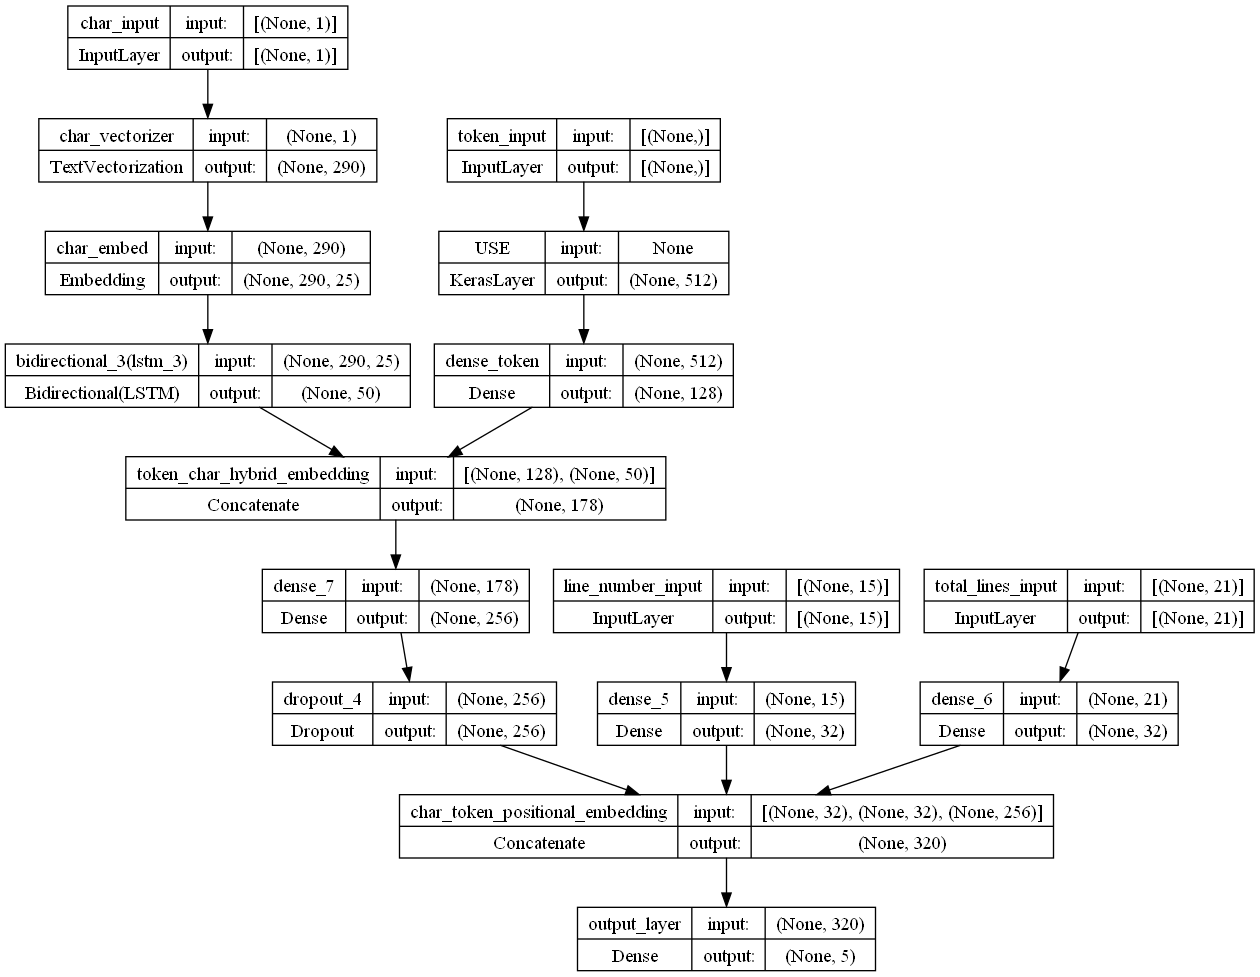

In [132]:
# Plot model_5 to explore it visually...
plot_model(model_5, show_shapes=True)

What is label smoothing ?

For example, if our model gets too confident on a single class (e.g its prediction probability is really high),
it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does it is assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resources:** For more on labl smoothing, see this blog post from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [195]:
# Compile token, character and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [85]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, 
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [129]:
# Check the input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [197]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 113ms/step - loss: 1.1001 - accuracy: 0.7201 - val_loss: 0.9853 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 63s 112ms/step - loss: 0.9664 - accuracy: 0.8168 - val_loss: 0.9485 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 63s 113ms/step - loss: 0.9491 - accuracy: 0.8251 - val_loss: 0.9367 - val_accuracy: 0.8338


In [131]:
# Evaluate on the whole validation dataset
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.9366 - accuracy: 0.8334


[0.9365903735160828, 0.833377480506897]

In [132]:
# Make predictions with the char, token, pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 26s 25ms/step


array([[0.50743175, 0.10260109, 0.0109498 , 0.3618114 , 0.01720593],
       [0.51352495, 0.08872412, 0.04810541, 0.3389054 , 0.01074006],
       [0.22309943, 0.14154337, 0.11556512, 0.44802544, 0.07176664],
       ...,
       [0.03565769, 0.11634588, 0.04396223, 0.02827184, 0.7757623 ],
       [0.02766716, 0.29158652, 0.07590737, 0.02744394, 0.5773951 ],
       [0.17113078, 0.624197  , 0.09900977, 0.03840791, 0.06725459]],
      dtype=float32)

In [133]:
# Format pred probs into pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [134]:
# Gets results of token-char-pos-hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.33774659075864,
 'precision': 0.8323932680988693,
 'recall': 0.8333774659075864,
 'f1': 0.8325327683779928}

In [135]:
all_model_results = pd.DataFrame({"baseline_0":baseline_results,
                                  "Conv1D with token embeddings":model_1_results,
                                  "NLP sequential model using pretrained embeddings":model_2_fe_results,
                                  "Character embeddings":model_3_results,
                                  "Hybrid embedding layer":model_4_results,
                                  "Tribrid embedding model":model_5_results
                                 }
                                 )
all_model_results = all_model_results.transpose().sort_values("f1", ascending=False)
all_model_results

,accuracy,precision,recall,f1
Tribrid embedding model,83.337747,0.832393,0.833377,0.832533
Conv1D with token embeddings,80.643453,0.804203,0.806435,0.804597
Hybrid embedding layer,73.583344,0.736512,0.735833,0.732706
NLP sequential model using pretrained embeddings,71.342513,0.713691,0.713425,0.710516
baseline_0,72.183238,0.718647,0.721832,0.698925
Character embeddings,65.066861,0.641478,0.650669,0.639664


In [136]:
# Reduce the accuracy to same scale as other metrics 
all_model_results["accuracy"] = all_model_results["accuracy"]/100

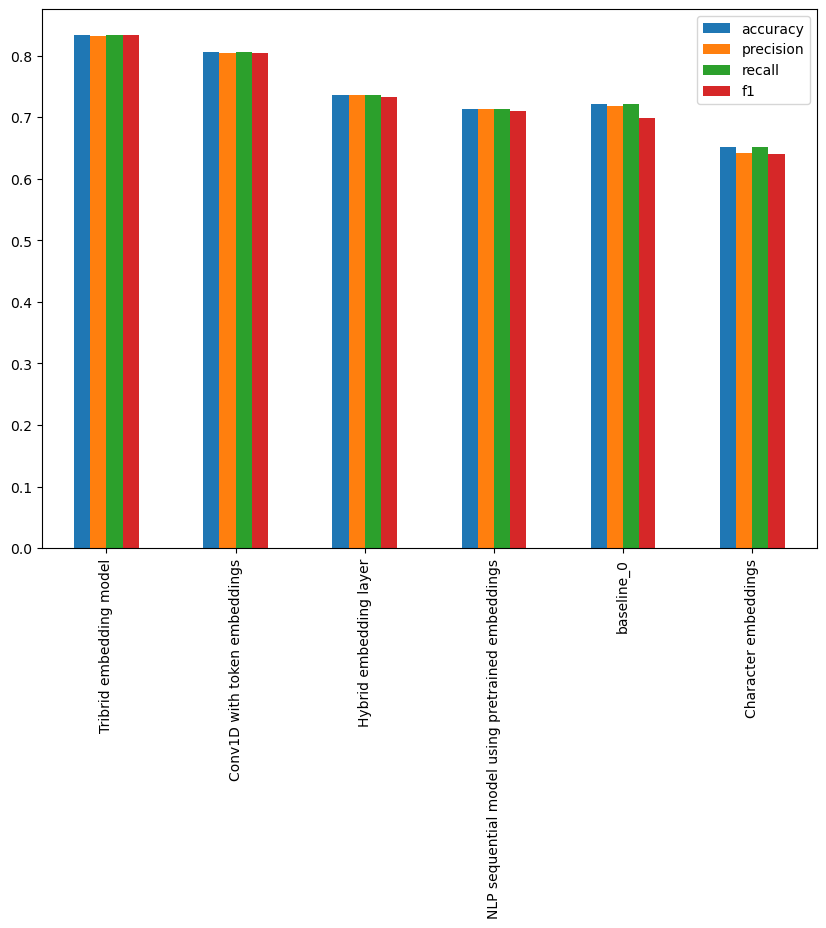

In [137]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

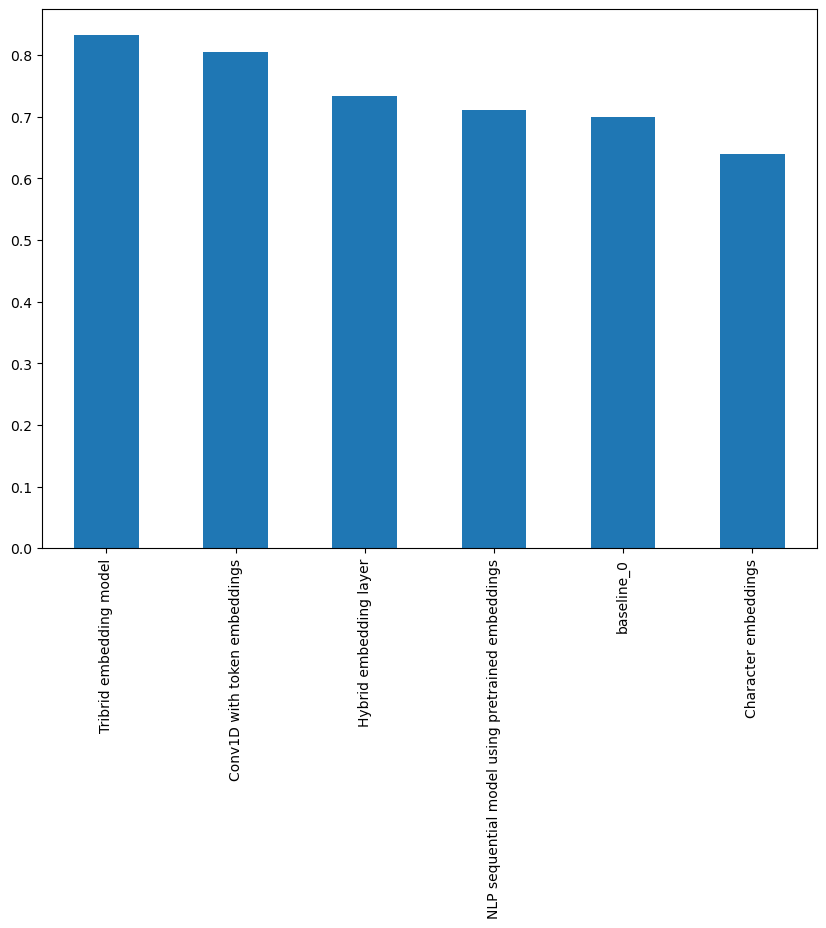

In [138]:
all_model_results["f1"].plot(kind="bar", figsize=(10, 7))

In [198]:
# Save the best performaing model to SaveModel format
model_5.save('G:\Mon Drive\SkimLit\Save\Tribrid embedding model', save_format='tf')

INFO:tensorflow:Assets written to: G:\Mon Drive\SkimLit\Save\Tribrid embedding model\assets


INFO:tensorflow:Assets written to: G:\Mon Drive\SkimLit\Save\Tribrid embedding model\assets


In [86]:
# Load in best performing model
model_5_loaded = tf.keras.models.load_model('G:\Mon Drive\SkimLit\Save\Tribrid embedding model')

In [88]:
# Make predictions with the loaded model on the validation set
model_5_loaded_pred_probs = model_5_loaded.predict(val_char_token_pos_dataset)

945/945 [==============================] - 12s 11ms/step


In [89]:
# Format pred probs into pred labels
model_5_loaded_preds = tf.argmax(model_5_loaded_pred_probs, axis=1)

In [90]:
model_5_loaded_results = calculate_results(y_true=val_labels_encoded,
                                           y_pred=model_5_loaded_preds)
model_5_loaded_results

{'accuracy': 83.55951277638025,
 'precision': 0.8342351131275545,
 'recall': 0.8355951277638025,
 'f1': 0.8345004623236499}

In [144]:
assert model_5_results ==  model_5_loaded_results

In [145]:
# Check the model loaded summary()
model_5_loaded.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['t

## Download and load in a pretrained model from Google Storage


In [146]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [147]:
# !curl -O https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  917M    0 82138    0     0  74877      0  3:34:10  0:00:01  3:34:09 74875
  1  917M    1 12.4M    0     0  6237k      0  0:02:30  0:00:02  0:02:28 6236k
  3  917M    3 29.7M    0     0   9.7M      0  0:01:33  0:00:03  0:01:30  9.7M
  4  917M    4 42.0M    0     0  10.4M      0  0:01:28  0:00:04  0:01:24 10.4M
  6  917M    6 55.6M    0     0  10.9M      0  0:01:23  0:00:05  0:01:18 11.0M
  8  917M    8 81.2M    0     0  13.4M      0  0:01:08  0:00:06  0:01:02 16.4M
 11  917M   11  104M    0     0  14.8M      0  0:01:01  0:00:07  0:00:54 18.4M
 14  917M   14  130M    0     0  16.1M      0  0:00:56  0:00:08  0:00:48 19.9M
 15  917M   15  144M    0     0  15.9M      0  0:00

In [148]:
# import zipfile

# zip_path = 'skimlit_tribrid_model.zip'
# extract_path = 'G:\Mon Drive\SkimLit'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)


In [149]:
# Load in downloaded Google Storage model
# loaded_gs_model = tf.keras.models.load_model("G:\Mon Drive\SkimLit\skimlit_tribrid_model")

In [150]:
# Evaluate the loaded Google Storage model
model_5_loaded.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 29s 28ms/step - loss: 0.9366 - accuracy: 0.8334


[0.9365903735160828, 0.833377480506897]